In [50]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [51]:
# Path to image and masks
image_dir = "/content/drive/MyDrive/HOT_OSM/train/images"
mask_dir = "/content/drive/MyDrive/HOT_OSM/train/masks"
val_image_dir = "/content/drive/MyDrive/HOT_OSM/validation/images"
val_mask_dir = "/content/drive/MyDrive/HOT_OSM/validation/masks"

In [52]:
# using the glob.glob function to get the names of the images
image_names = glob.glob(image_dir + "/*png")
print(image_names)

['/content/drive/MyDrive/HOT_OSM/train/images/42.png', '/content/drive/MyDrive/HOT_OSM/train/images/96.png', '/content/drive/MyDrive/HOT_OSM/train/images/22.png', '/content/drive/MyDrive/HOT_OSM/train/images/120.png', '/content/drive/MyDrive/HOT_OSM/train/images/143.png', '/content/drive/MyDrive/HOT_OSM/train/images/32.png', '/content/drive/MyDrive/HOT_OSM/train/images/8.png', '/content/drive/MyDrive/HOT_OSM/train/images/80.png', '/content/drive/MyDrive/HOT_OSM/train/images/141.png', '/content/drive/MyDrive/HOT_OSM/train/images/4.png', '/content/drive/MyDrive/HOT_OSM/train/images/89.png', '/content/drive/MyDrive/HOT_OSM/train/images/72.png', '/content/drive/MyDrive/HOT_OSM/train/images/101.png', '/content/drive/MyDrive/HOT_OSM/train/images/2.png', '/content/drive/MyDrive/HOT_OSM/train/images/99.png', '/content/drive/MyDrive/HOT_OSM/train/images/54.png', '/content/drive/MyDrive/HOT_OSM/train/images/115.png', '/content/drive/MyDrive/HOT_OSM/train/images/63.png', '/content/drive/MyDrive/H

In [53]:
# sorting the images according to the names
image_names.sort()
print(image_names)

['/content/drive/MyDrive/HOT_OSM/train/images/0.png', '/content/drive/MyDrive/HOT_OSM/train/images/1.png', '/content/drive/MyDrive/HOT_OSM/train/images/10.png', '/content/drive/MyDrive/HOT_OSM/train/images/100.png', '/content/drive/MyDrive/HOT_OSM/train/images/101.png', '/content/drive/MyDrive/HOT_OSM/train/images/102.png', '/content/drive/MyDrive/HOT_OSM/train/images/103.png', '/content/drive/MyDrive/HOT_OSM/train/images/104.png', '/content/drive/MyDrive/HOT_OSM/train/images/105.png', '/content/drive/MyDrive/HOT_OSM/train/images/106.png', '/content/drive/MyDrive/HOT_OSM/train/images/107.png', '/content/drive/MyDrive/HOT_OSM/train/images/108.png', '/content/drive/MyDrive/HOT_OSM/train/images/109.png', '/content/drive/MyDrive/HOT_OSM/train/images/11.png', '/content/drive/MyDrive/HOT_OSM/train/images/110.png', '/content/drive/MyDrive/HOT_OSM/train/images/111.png', '/content/drive/MyDrive/HOT_OSM/train/images/112.png', '/content/drive/MyDrive/HOT_OSM/train/images/113.png', '/content/drive

In [54]:
# We use the cv2.imread functino and a list comprehension to get the images in a specific order.
images = [cv2.imread(img, 0) for img in image_names]

In [55]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis=3)

In [56]:
# We will read and sort the masks, the same way we did the images.
mask_names = glob.glob(mask_dir + "/*png")
mask_names.sort()
masks = [cv2.imread(mask, 0) for mask in mask_names]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis=3)

In [57]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (145, 256, 256, 1)
Mask data shape is:  (145, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [58]:
# Normalize images
image_dataset = image_dataset / 255
mask_dataset = mask_dataset / 255

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, mask_dataset, test_size=0.10, random_state=42
)

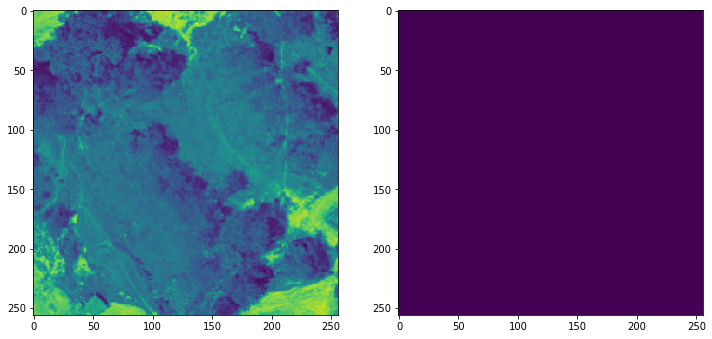

In [61]:
import random

image_number = random.randint(0, len(image_dataset) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number, :, :, 0])
plt.subplot(122)
plt.imshow(mask_dataset[image_number, :, :, 0])
plt.show()

In [68]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
    Conv2DTranspose,
    BatchNormalization,
    Dropout,
    Lambda,
)
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  # Not in the original network.
    x = Activation("swish")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("swish")(x)

    return x


# Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


# Decoder block
# skip features gets input from encoder for concatenation


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
        activation = "sigmoid"
    else:
        activation = "softmax"

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(
        d4
    )  # Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [69]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [70]:
model = build_unet(input_shape, n_classes=1)
model.compile(
    optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"]
)
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 256, 256, 64  256        ['conv2d_21[0][0]']              
 ormalization)                  )                                                     

In [71]:
history = model.fit(
    X_train,
    y_train,
    batch_size=7,
    verbose=1,
    epochs=100,
    validation_data=(X_test, y_test),
    shuffle=False,
)

Epoch 1/100
19/19 [==============================] - 34s 868ms/step - loss: 0.4884 - accuracy: 0.8125 - val_loss: 0.7929 - val_accuracy: 0.5681
Epoch 2/100
19/19 [==============================] - 10s 537ms/step - loss: 0.3842 - accuracy: 0.8559 - val_loss: 0.3932 - val_accuracy: 0.9114
Epoch 3/100
19/19 [==============================] - 10s 528ms/step - loss: 0.3561 - accuracy: 0.8553 - val_loss: 0.3455 - val_accuracy: 0.9192
Epoch 4/100
19/19 [==============================] - 10s 532ms/step - loss: 0.3492 - accuracy: 0.8550 - val_loss: 14.4819 - val_accuracy: 0.1281
Epoch 5/100
19/19 [==============================] - 10s 538ms/step - loss: 0.3478 - accuracy: 0.8531 - val_loss: 479.5581 - val_accuracy: 0.0925
Epoch 6/100
19/19 [==============================] - 10s 540ms/step - loss: 0.3455 - accuracy: 0.8552 - val_loss: 0.8963 - val_accuracy: 0.9171
Epoch 7/100
19/19 [==============================] - 10s 536ms/step - loss: 0.3331 - accuracy: 0.8562 - val_loss: 1.6642 - val_accura

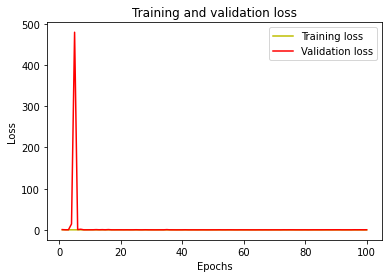

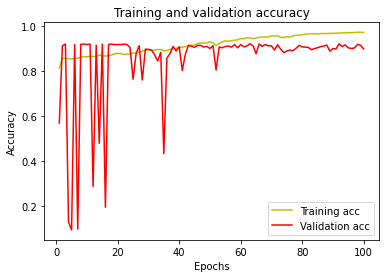

In [72]:
# plot the training and validation accuracy and loss at each epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "y", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()